## Self driving car model

In [9]:
!git clone https://github.com/tzudir/Self_driving

fatal: destination path 'Self_driving' already exists and is not an empty directory.


In [10]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Lambda, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import ntpath

In [15]:
datadir = '/content/Self_driving/data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)

In [16]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\realj\Documents\Car\IMG\center_2024_01_25_22_48_25_466.jpg,C:\Users\realj\Documents\Car\IMG\left_2024_01_25_22_48_25_466.jpg,C:\Users\realj\Documents\Car\IMG\right_2024_01_25_22_48_25_466.jpg,0.0,0.0,0.0,0.000091
1,C:\Users\realj\Documents\Car\IMG\center_2024_01_25_22_48_25_543.jpg,C:\Users\realj\Documents\Car\IMG\left_2024_01_25_22_48_25_543.jpg,C:\Users\realj\Documents\Car\IMG\right_2024_01_25_22_48_25_543.jpg,0.0,0.0,0.0,0.000116
2,C:\Users\realj\Documents\Car\IMG\center_2024_01_25_22_48_25_622.jpg,C:\Users\realj\Documents\Car\IMG\left_2024_01_25_22_48_25_622.jpg,C:\Users\realj\Documents\Car\IMG\right_2024_01_25_22_48_25_622.jpg,0.0,0.0,0.0,0.000132
3,C:\Users\realj\Documents\Car\IMG\center_2024_01_25_22_48_25_700.jpg,C:\Users\realj\Documents\Car\IMG\left_2024_01_25_22_48_25_700.jpg,C:\Users\realj\Documents\Car\IMG\right_2024_01_25_22_48_25_700.jpg,0.0,0.0,0.0,0.000161
4,C:\Users\realj\Documents\Car\IMG\center_2024_01_25_22_48_25_769.jpg,C:\Users\realj\Documents\Car\IMG\left_2024_01_25_22_48_25_769.jpg,C:\Users\realj\Documents\Car\IMG\right_2024_01_25_22_48_25_769.jpg,0.0,0.0,0.0,0.000227


In [17]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [18]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2024_01_25_22_48_25_466.jpg,left_2024_01_25_22_48_25_466.jpg,right_2024_01_25_22_48_25_466.jpg,0.0,0.0,0.0,0.000091
1,center_2024_01_25_22_48_25_543.jpg,left_2024_01_25_22_48_25_543.jpg,right_2024_01_25_22_48_25_543.jpg,0.0,0.0,0.0,0.000116
2,center_2024_01_25_22_48_25_622.jpg,left_2024_01_25_22_48_25_622.jpg,right_2024_01_25_22_48_25_622.jpg,0.0,0.0,0.0,0.000132
3,center_2024_01_25_22_48_25_700.jpg,left_2024_01_25_22_48_25_700.jpg,right_2024_01_25_22_48_25_700.jpg,0.0,0.0,0.0,0.000161
4,center_2024_01_25_22_48_25_769.jpg,left_2024_01_25_22_48_25_769.jpg,right_2024_01_25_22_48_25_769.jpg,0.0,0.0,0.0,0.000227


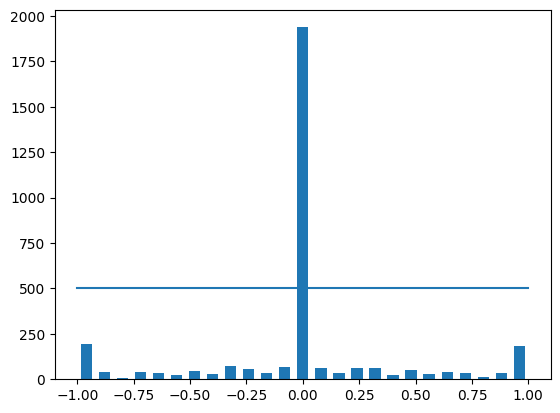

In [20]:
num_bins = 25
samples_per_bin = 500
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [21]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

removed:  1438
remaining:  1767


In [22]:
hist, bins = np.histogram(data['steering'], (num_bins))

In [23]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [24]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [25]:
image_paths

array(['/content/Self_driving/data/IMG/center_2024_01_25_22_48_25_466.jpg',
       '/content/Self_driving/data/IMG/left_2024_01_25_22_48_25_466.jpg',
       '/content/Self_driving/data/IMG/right_2024_01_25_22_48_25_466.jpg',
       ...,
       '/content/Self_driving/data/IMG/center_2024_02_02_09_53_08_948.jpg',
       '/content/Self_driving/data/IMG/left_2024_02_02_09_53_08_948.jpg',
       '/content/Self_driving/data/IMG/right_2024_02_02_09_53_08_948.jpg'],
      dtype='<U65')

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state = 6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 4240
Valid Samples: 1061


Text(0.5, 1.0, 'Validation set')

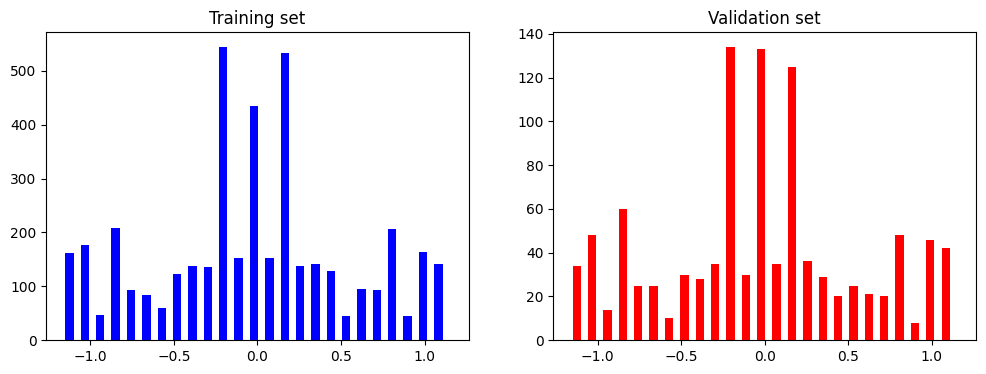

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [28]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle


In [29]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

In [30]:
def img_preprocess(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

In [31]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [32]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (5, 5), activation='elu'))


  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))

  model.add(Dense(50, activation = 'elu'))

  model.add(Dense(10, activation = 'elu'))


  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 18, 64)         76864     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               115300    
                                                                 
 dense_1 (Dense)             (None, 50)                5

In [33]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

<ipython-input-33-c6c3380b9281>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),


Epoch 1/10
300/300 [==============================] - 121s 380ms/step - loss: 0.3214 - val_loss: 0.2694
Epoch 2/10
300/300 [==============================] - 127s 426ms/step - loss: 0.2520 - val_loss: 0.2377
Epoch 3/10
300/300 [==============================] - 113s 379ms/step - loss: 0.2210 - val_loss: 0.2069
Epoch 4/10
300/300 [==============================] - 114s 380ms/step - loss: 0.2032 - val_loss: 0.1931
Epoch 5/10
300/300 [==============================] - 115s 386ms/step - loss: 0.1922 - val_loss: 0.1745
Epoch 6/10
300/300 [==============================] - 159s 531ms/step - loss: 0.1871 - val_loss: 0.1662
Epoch 7/10
300/300 [==============================] - 121s 404ms/step - loss: 0.1723 - val_loss: 0.1668
Epoch 8/10
300/300 [==============================] - 107s 357ms/step - loss: 0.1702 - val_loss: 0.1627
Epoch 9/10
300/300 [==============================] - 105s 351ms/step - loss: 0.1627 - val_loss: 0.1414
Epoch 10/10
300/300 [==============================] - 135s 451m

Text(0.5, 0, 'Epoch')

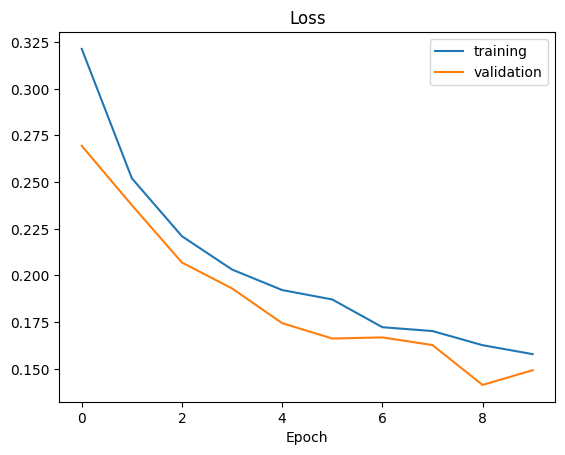

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [36]:
model.save('model1.h5')
from google.colab import files
files.download('model1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>